In [3]:
import os
import pickle
import pandas as pd
import numpy as np
import time
from utils import raw_data_path, feature_data_path,result_path,model_path,cache_pkl_path,dump_pickle,load_pickle

In [2]:
all_data = load_pickle(raw_data_path + 'all_data_6_7.pkl')

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
import lda

def get_item_property_doc(item_category_list, item_property_list):
    item_category_list = [category for category in item_category_list.split(";") if category != '-1']
    item_property_list = [item_property for item_property in item_property_list.split(";") if item_property != '-1']
    item_category_list = item_category_list
    item_property_list = item_property_list[:10]
    doc = list()
    for item_category in item_category_list:
        doc.append('c_' + item_category)
    for item_property in item_property_list:
        doc.append(item_property)
    return ';'.join(doc)

    
def get_predict_property_doc(item_category_list, predict_category_property_list):

    doc = list()
#     只取前五个预测类别
    for predict_category_property in predict_category_property_list.split(";")[:5]:
        if predict_category_property != '-1':
            category = predict_category_property.split(":")[0]
            if category != -1:
                doc.append('c_' + category)
            property_list = predict_category_property.split(":")[1]
            if property_list != -1:
                for item_property in property_list.split(','):
                    doc.append(item_property)
    return ';'.join(doc)

def category_property_iter():
    for item_property_doc in all_data['item_property_doc']:
        yield item_property_doc
        
    for predict_category_property_doc in all_data['predict_property_doc']:
        yield predict_category_property_doc


In [4]:
print('-----read all data-----')
    

def split(s):
    return s.split(';')

all_data['item_property_doc'] = all_data.apply(lambda row: get_item_property_doc(row['item_category_list'], row['item_property_list']), axis=1)
all_data['predict_property_doc'] = all_data.apply(lambda row: get_predict_property_doc(row['item_category_list'], row['predict_category_property']), axis=1)


cv = CountVectorizer(analyzer=split)
cv.fit(category_property_iter())
count_vector_item_property = cv.transform(all_data['item_property_doc'])
count_vector_predict_property = cv.transform(all_data['predict_property_doc'])

print('Shape of item_property Count Vector: {}'.format(count_vector_item_property.shape))
print('Shape of predict_property Count Vector: {}'.format(count_vector_predict_property.shape))

-----read all data-----
Shape of item_property Count Vector: (3531506, 38099)
Shape of predict_property Count Vector: (3531506, 38099)


In [7]:
dump_pickle(count_vector_item_property, model_path + 'count_vector_item_property.pkl')
dump_pickle(count_vector_predict_property, model_path + 'count_vector_predict_property.pkl')

In [ ]:
k = 30

lda_model = lda.LDA(n_topics=k, n_iter=1000, random_state=1, refresh=20)
lda_model.fit(count_vector)

dump_pickle(lda_model, model_path + 'lda_model_test_0428.pkl')

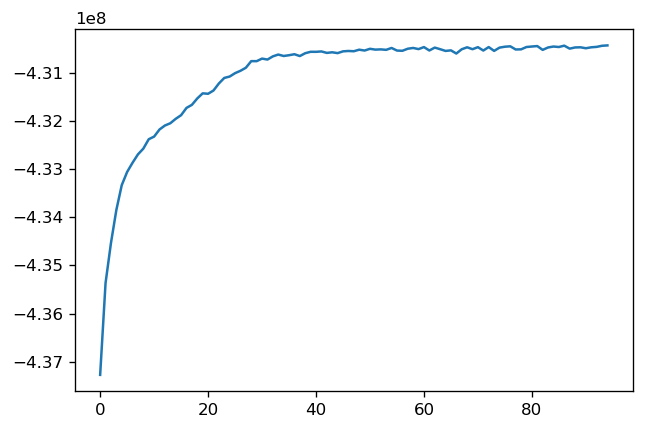

In [4]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120
import matplotlib.pyplot as plt

lda_model = load_pickle(model_path + '4567_item_property_lda_model_k_15.pkl')
plt.plot(lda_model.loglikelihoods_[5:])

In [9]:
data = all_data

lda_model = load_pickle(model_path + 'lda_model_test_0428.pkl')

k = 30
topic_vector = lda_model.doc_topic_

# topic = topic_vector.argmax(axis=1)
# topic = pd.Series(topic)

topic_vector = pd.DataFrame(topic_vector)
for i in range(k):
    topic_vector.rename(columns={i: 'item_property_topic_' + str(i)}, inplace=True)
print('Shape of Topic Distributions: {}'.format(topic_vector.shape))

# data = pd.concat([data, topic_vector, topic], axis=1)
# data.rename(columns={0: 'item_property_topic'}, inplace=True)

dump_pickle(topic_vector, model_path + 'topic_vector_k_30.pkl')

Shape of Topic Distributions: (3531506, 30)


In [3]:
lda_model = load_pickle(model_path + 'lda_model_test_0428.pkl')

count_vector_item_property = load_pickle(model_path + 'count_vector_item_property.pkl')
count_vector_predict_property = load_pickle(model_path + 'count_vector_predict_property.pkl')

print(count_vector_item_property.shape, count_vector_predict_property.shape)

(3531506, 38099) (3531506, 38099)


(100, 30)

In [ ]:
doc_topic_predict = lda_model.transform(count_vector_predict_property)
doc_topic_predict.shape

In [ ]:
dump_pickle(doc_topic_predict, model_path + 'doc_topic_predict.pkl')

In [ ]:
from utils import extract_ctr
extract_ctr(data[(data.is_trade != -1) & (data.day == 7)], feature='item_property_topic', alias='feature_ctr')

## 没用

In [37]:
def f(s, x):
    s[len(str(x).split(';'))] += 1

def c(x):
    global cnt
    cnt += len(str(x).split(';')[:10])
    

# s = [0 for _ in range(1000)]


# le.fit(list(interest_set))

s = set()

cnt = 0
all_data.item_property_list.apply(lambda x: s.update(x.split(';')[:10])) 
# train_data.item_property_list.apply(lambda x: s.add(len(str(x).split(';')))) 
# data.item_property_list.apply(lambda x: f(s, x)) 

# data.item_property_list.apply(lambda x: c(x)) 

len(s)

2912

In [33]:
from sklearn.feature_extraction.text import CountVectorizer
import lda

def get_item_property_doc(item_category_list, item_property_list):
    item_category_list = [category for category in item_category_list.split(";") if category != '-1']
    item_property_list = [item_property for item_property in item_property_list.split(";") if item_property != '-1']
    
#     要不要算category0 ????
    item_category_list = item_category_list[1:]
    item_property_list = item_property_list[:10]
    doc = list()
    for item_category in item_category_list:
        for item_property in item_property_list:
            doc.append(item_category + '_' + item_property)
    return ';'.join(doc)

    
def get_predict_property_doc(item_category_list, predict_category_property_list):

    item_category_list = [category for category in item_category_list.split(";") if category != '-1']
    doc = list()
#     只取前五个预测类别
    for predict_category_property in predict_category_property_list.split(";")[:5]:
        if predict_category_property != '-1':
            category = predict_category_property.split(":")[0]
            property_list = predict_category_property.split(":")[1]
            if property_list != -1:
                for item_property in property_list.split(','):
                    doc.append(category + '_' + item_property)
    return ';'.join(doc)

def category_property_iter():
    for item_property_doc in all_data['item_property_doc']:
        yield item_property_doc
        
    for predict_category_property_doc in all_data['predict_property_doc']:
        yield predict_category_property_doc

print('-----read all data-----')
    
k = 20

def split(s):
    return s.split(';')

all_data['item_property_doc'] = all_data.apply(lambda row: get_item_property_doc(row['item_category_list'], row['item_property_list']), axis=1)
all_data['predict_property_doc'] = all_data.apply(lambda row: get_predict_property_doc(row['item_category_list'], row['predict_category_property']), axis=1)


cv = CountVectorizer(analyzer=split)
cv.fit(category_property_iter())
count_vector = cv.transform(all_data['item_property_doc'])

# count_vector = cv.fit_transform(all_data['item_property_doc'])

print('Shape of Count Vector: {}'.format(count_vector.shape))

lda_model = lda.LDA(n_topics=k, n_iter=2000, random_state=1, refresh=100)
lda_model.fit(count_vector)

dump_pickle(lda_model, model_path + 'lda_model_test.pkl')

-----read all data-----


INFO:lda:n_documents: 10000
INFO:lda:vocab_size: 10822
INFO:lda:n_words: 139024
INFO:lda:n_topics: 20
INFO:lda:n_iter: 2000


Shape of Count Vector: (10000, 10822)


INFO:lda:<0> log likelihood: -1704505
INFO:lda:<100> log likelihood: -755547
INFO:lda:<200> log likelihood: -754043
INFO:lda:<300> log likelihood: -753641
INFO:lda:<400> log likelihood: -753729
INFO:lda:<500> log likelihood: -751754
INFO:lda:<600> log likelihood: -751738
INFO:lda:<700> log likelihood: -751715
INFO:lda:<800> log likelihood: -751701
INFO:lda:<900> log likelihood: -751355
INFO:lda:<1000> log likelihood: -751656
INFO:lda:<1100> log likelihood: -751632
INFO:lda:<1200> log likelihood: -751774
INFO:lda:<1300> log likelihood: -751570
INFO:lda:<1400> log likelihood: -751625
INFO:lda:<1500> log likelihood: -751611
INFO:lda:<1600> log likelihood: -751575
INFO:lda:<1700> log likelihood: -751500
INFO:lda:<1800> log likelihood: -751780
INFO:lda:<1900> log likelihood: -751715
INFO:lda:<1999> log likelihood: -751884
